<h1 align='center'>Классификация изображений с pyTorch Lightning </h1>

## Загрузка данных c Kaggle



In [ ]:
# модный widget загрузки
from google.colab import files
files.upload()

In [ ]:
# создаем директорию kaggle и копируем файл в нее,
# добавляя разрешение на запись и чтение
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# список датасетов с ключевым словом поиска
!kaggle datasets list -s "weather-dataset"

ref                                                             title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
guillemservera/global-daily-climate-data                        The Weather Dataset                           213MB  2023-09-03 04:04:45           2040         46  1.0              
yakinrubaiat/bangladesh-weather-dataset                         Bangladesh Weather Dataset                     14KB  2019-04-20 06:06:34           2870         49  0.88235295       
muthuj7/weather-dataset                                         Weather Dataset                                 2MB  2017-12-04 23:52:09          34409        263  0.29411766       
pratik2901/multiclass-weather-dataset                           Multi-class Weather Datase

In [ ]:
# скачиваем сет
!kaggle datasets download -d "jehanbhathena/weather-dataset"

 97% 571M/587M [00:05<00:00, 99.5MB/s]
100% 587M/587M [00:05<00:00, 118MB/s] 


In [ ]:
%%capture
# распаковка сета
!unzip weather-dataset.zip

In [ ]:
# удаляем лишнее
!rm weather-dataset.zip

## Подготовка



In [ ]:
!pip install -q split-folders pytorch_lightning==1.5.10 efficientnet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 37.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
arviz 0.15.1 requires setuptools>=60.0.0, but you have setuptools 59.5.0 which is incompatible.
cvxpy 1.3.3 requires setuptools>65.5.1, but you have setuptools 59.5.0 which is incompatible.


In [ ]:
# библиотеки для работы с изображениями
import cv2
from PIL import Image
import numpy as np
# библиотека для работы с путями
from pathlib import Path
# вспомогательные
import matplotlib.pyplot as plt

# для работы
import torch
import torch.nn as nn
import torch.nn.functional as F
import splitfolders
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torchmetrics import Accuracy
from efficientnet_pytorch import EfficientNet


# автоматическое логивароение результатов
from pytorch_lightning.loggers import TensorBoardLogger
# сохранение весов
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
# автоматическое отслеживание lr
# from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import LearningRateMonitor
# ранние остановки
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# дополнительные импорты
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report
import warnings


# сахар опционально :)
SEED = 42
pl.seed_everything(SEED)
plt.style.use('dark_background')
warnings.filterwarnings("ignore")

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


In [ ]:
DATASET = Path("/content/dataset")

In [ ]:
# пробегаем по директории с картинками и добавляем в список
images = [p.resolve() for p in DATASET.glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]

In [ ]:
images[:3]

[PosixPath('/content/dataset/frost/4064.jpg'),
 PosixPath('/content/dataset/frost/3784.jpg'),
 PosixPath('/content/dataset/frost/4021.jpg')]

In [ ]:
len(images)

6862

In [ ]:
sample_idx = np.random.randint(len(images))
sample_idx

860

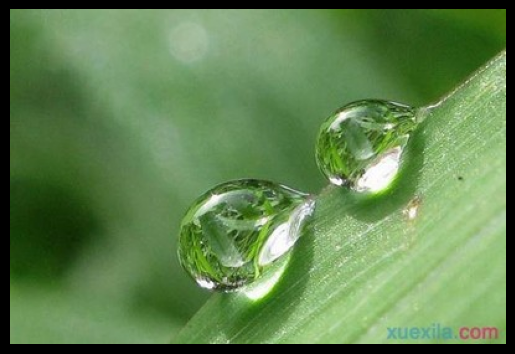

In [ ]:
img = Image.open(images[sample_idx]) # RGB!
plt.imshow(img)
plt.axis("off")
plt.show()

# Разбивка сета с изображениями

In [ ]:
splitfolders.ratio(
                    "/content/dataset",
                    output="weather_split",
                    seed=42,
                    ratio=(.8, .1, .1),
                    group_prefix=None,
                    move=False
)

Copying files: 6862 files [00:06, 1017.66 files/s]


In [ ]:
images = [p.resolve() for p in Path("/content/weather_split/train").glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]
len(images)

5484

# Datamodule для загрузки данных

In [ ]:
class ImgDataModule(pl.LightningDataModule):
  def __init__(self,
               batch_size = 1,
               train_transform=None,
               val_transform=None,
               img_root = "./weather_split"
               ):
    super().__init__()
    self.batch_size = batch_size
    self.train_transform = train_transform
    self.val_transform = val_transform
    self.img_root = img_root

  def setup(self, stage=None):
    # метод содержит информацию о датасете
    self.train_set = ImageFolder(self.img_root / Path("train"), transform=self.train_transform)
    self.val_set = ImageFolder(self.img_root / Path("val"), transform=self.val_transform)
    self.test_set = ImageFolder(self.img_root / Path("test"), transform=self.val_transform)

  def train_dataloader(self):
    # метод создает загрузчик
    return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=2)

  def val_dataloader(self):
    return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=2)

  def test_dataloader(self):
    return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=2)

In [ ]:
dm = ImgDataModule()

In [ ]:
dm.setup()

In [ ]:
{k:v for k, v in enumerate(dm.test_set.classes)}

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

# Создание модели pyTorchLightning

In [ ]:
class EffNetClassifier(pl.LightningModule):
  # обязательный метод
  def __init__(self,
               model = "efficientnet-b0",
               in_channels = 3,
               out_classes = 11,
               eta = 3e-4,
               **kwargs):
    super().__init__()
    self.save_hyperparameters()
    self.model = EfficientNet.from_pretrained(model,
                                              num_classes = out_classes,
                                              in_channels = in_channels)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    self.out_classes = out_classes
    self.criterion = nn.CrossEntropyLoss()
    self.metrics = {"accuracy": Accuracy(task="multiclass", num_classes=out_classes).to(device)}
  # обязательный метод
  def forward(self, x):
    return self.model(x)
  # метод общий для всех
  def shared_step(self,
                  sample,
                  stage):
    x, y = sample
    logits = self.forward(x.to(torch.float32))
    preds = torch.argmax(logits, 1)
    loss = self.criterion(logits, y.to(torch.int64))

    return {
            'loss': loss,
            'accuracy': self.metrics["accuracy"](preds, y)
    }
  # метод общий для всех
  def shared_epoch_end(self,
                       outputs,
                       stage):
    loss = np.mean([x["loss"].item() for x in outputs])
    acc = np.mean([x["accuracy"].item() for x in outputs])

    metrics = {

        f"{stage}_loss": loss,
        f"{stage}_acc": acc
    }

    self.log_dict(metrics, prog_bar=True)
  # обязательный шаг - создаем оптимизатор, шедулер
  def configure_optimizers(self):
    optimizer = torch.optim.SGD(
        self.parameters(),
        lr = self.hparams.eta)
    scheduler_dict = {
        "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5),
        "interval": "epoch",
        "monitor": "valid_loss"
    }
    return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

  # шаг обучения
  def training_step(self,
                    batch,
                    batch_idx):
    return self.shared_step(batch, 'train')
  # шаг подсчета метрик обучения
  def training_epoch_end(self,
                    outputs):
    return self.shared_epoch_end(outputs, 'train')
  # шаг валидации
  def validation_step(self,
                    batch,
                    batch_idx):
    return self.shared_step(batch, 'valid')
  # шаг подсчета метрик валидации
  def validation_epoch_end(self,
                    outputs):
    return self.shared_epoch_end(outputs, 'valid')
  # шаг тестирования
  def test_step(self,
                    batch,
                    batch_idx):
    return self.shared_step(batch, 'test')
  # шаг подсчета метрик тестирования
  def test_epoch_end(self,
                    outputs):
    return self.shared_epoch_end(outputs, 'test')

# Запуск обучения

Нормализация:

In [ ]:
# трансформации для обучения
transform_train = transforms.Compose(

                [transforms.Resize((224, 224)),
                 transforms.RandomHorizontalFlip(p=.5),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
                 ]
)

# трансформации для валидации и теста
# (сохраняем только ресайз, тензор и нормализацию)
transform_test = transforms.Compose(

                [transforms.Resize((224, 224)),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
                 ]
)

In [ ]:
BATCH = 16
# создаем DataModule-экземпляр
dm = ImgDataModule(BATCH, transform_train, transform_test)
EXPERIMENT = "efficientnet-b0"
ETA = 3*10e-3
model = EffNetClassifier(eta=ETA, model=EXPERIMENT)
# список для отслеживания lr, ранних остановок, сохранения весов
callbacks = [

            ModelCheckpoint(
                dirpath='models',
                filename='{epoch}_{valid_acc:.2f}_{valid_loss:.2f}',
                save_top_k=2,
                monitor='valid_loss',
                mode='min'
            ),

             LearningRateMonitor(logging_interval="step"),
             EarlyStopping(monitor="valid_loss",
                           min_delta=2e-4,
                           patience=10,
                           verbose=False,
                           mode="min")
]


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 152MB/s]


Loaded pretrained weights for efficientnet-b0


In [ ]:
# указываем путь для логирования и логер
TENSOR = "./logs"
logger = TensorBoardLogger(TENSOR, name=EXPERIMENT)
# стартуем с нуля, поэтому передаем тут checkpoint None
CHECKPOINT = None
# создаем трейнер - класс, который будет обучать
trainer = pl.Trainer(
        gpus=1,
        max_epochs=10,
        logger=logger,
        callbacks=callbacks,
        resume_from_checkpoint=CHECKPOINT
)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


In [ ]:
# любимый fit
trainer.fit(model, dm)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | EfficientNet     | 4.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.087    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Тестирование и Tensorboard

In [ ]:
# тестирование
trainer.test(model, dm)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.921875, 'test_loss': 0.265465729972427}
--------------------------------------------------------------------------------


[{'test_loss': 0.265465729972427, 'test_acc': 0.921875}]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/logs/efficientnet-b0

# Работа с моделью после обучения

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
weights = "/content/models/epoch=5_valid_acc=0.92_valid_loss=0.26.ckpt"
model = EffNetClassifier.load_from_checkpoint(weights)

Loaded pretrained weights for efficientnet-b0


In [ ]:
model = model.to(DEVICE)

In [ ]:
# test
test = dm.test_dataloader()

In [ ]:
# список предсказаний
predictions = []
# список целевых
targets = []
# тут уже не забываем про eval() и no_grad()
model.eval()
with torch.no_grad():
    # перебираем батчи в тесте
    for X, y in tqdm(test):
        # через argmax находим классы
        outputs = torch.argmax(model(X.to(torch.float32).to(DEVICE)), 1)
        predictions.append(outputs.detach())
        targets.append(y.detach())

predictions = (torch.cat(predictions)).cpu().numpy()
targets = (torch.cat(targets)).cpu().numpy()

  0%|          | 0/44 [00:00<?, ?it/s]

In [ ]:
classes = dm.test_set.classes
print(classification_report(targets, predictions, target_names=classes))

              precision    recall  f1-score   support

         dew       0.96      0.97      0.97        71
     fogsmog       0.99      0.93      0.96        86
       frost       0.88      0.75      0.81        48
       glaze       0.74      0.83      0.78        65
        hail       0.92      1.00      0.96        60
   lightning       1.00      1.00      1.00        39
        rain       0.94      0.91      0.92        54
     rainbow       1.00      1.00      1.00        24
        rime       0.93      0.84      0.89       116
   sandstorm       0.94      0.97      0.96        70
        snow       0.81      0.92      0.86        63

    accuracy                           0.91       696
   macro avg       0.92      0.92      0.92       696
weighted avg       0.92      0.91      0.91       696



In [ ]:
!wget https://cdnn1.img.sputnik.tj/img/07e5/06/1c/1040498811_0:183:2995:1867_1920x0_80_0_0_4f99b9f73fd1e3686d26f4de46c6bacf.jpg -O 001.jpg

--2023-06-23 07:56:29--  https://cdnn1.img.sputnik.tj/img/07e5/06/1c/1040498811_0:183:2995:1867_1920x0_80_0_0_4f99b9f73fd1e3686d26f4de46c6bacf.jpg
Resolving cdnn1.img.sputnik.tj (cdnn1.img.sputnik.tj)... 185.40.155.13
Connecting to cdnn1.img.sputnik.tj (cdnn1.img.sputnik.tj)|185.40.155.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘001.jpg’

001.jpg                 [  <=>               ] 320.54K  1.03MB/s    in 0.3s    

2023-06-23 07:56:30 (1.03 MB/s) - ‘001.jpg’ saved [328228]



In [ ]:
!wget https://vsegda-pomnim.com/uploads/posts/2022-02/1645922448_15-vsegda-pomnim-com-p-grad-foto-18.jpg -O 003.jpg

--2023-06-23 07:56:30--  https://vsegda-pomnim.com/uploads/posts/2022-02/1645922448_15-vsegda-pomnim-com-p-grad-foto-18.jpg
Resolving vsegda-pomnim.com (vsegda-pomnim.com)... 146.59.9.33
Connecting to vsegda-pomnim.com (vsegda-pomnim.com)|146.59.9.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118343 (116K) [image/jpeg]
Saving to: ‘003.jpg’

003.jpg             100%[===================>] 115.57K   508KB/s    in 0.2s    

2023-06-23 07:56:31 (508 KB/s) - ‘003.jpg’ saved [118343/118343]



In [ ]:
!wget https://cs1.livemaster.ru/storage/20/9c/5debc9f1fbcb9144d78807f3fcal--ukrasheniya-brosh-so-srezom-agata-vspominaya-osen.jpg -O 004.jpg

--2023-06-23 07:56:31--  https://cs1.livemaster.ru/storage/20/9c/5debc9f1fbcb9144d78807f3fcal--ukrasheniya-brosh-so-srezom-agata-vspominaya-osen.jpg
Resolving cs1.livemaster.ru (cs1.livemaster.ru)... 46.229.162.174
Connecting to cs1.livemaster.ru (cs1.livemaster.ru)|46.229.162.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96216 (94K) [image/jpeg]
Saving to: ‘004.jpg’

004.jpg             100%[===================>]  93.96K   387KB/s    in 0.2s    

2023-06-23 07:56:33 (387 KB/s) - ‘004.jpg’ saved [96216/96216]



In [ ]:
files.upload()

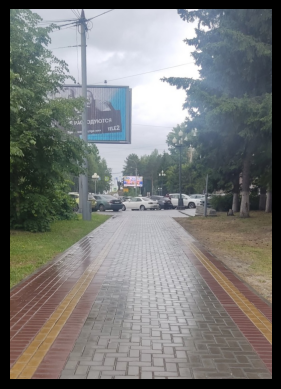

In [ ]:
img = Image.open("/content/777.jpg")
plt.axis("off")
plt.imshow(img);

In [ ]:
input = transform_test(img)
input.unsqueeze(0).size()

torch.Size([1, 3, 224, 224])

In [ ]:
model.eval()
with torch.no_grad():
  out = model(input.unsqueeze(0).to(DEVICE))

In [ ]:
out_vec = out.cpu().numpy()
idx = np.argmax(out_vec)

In [ ]:
print(idx, dm.test_set.classes[idx])

6 rain
